In [1]:
from map_search import optimize_rot_trans, downsample_vol, symmetrize_ht3, grid_3d, optimize_rot_trans_chunked

In [2]:
from cryodrgn import mrcfile as mrc
vol1, _ = mrc.parse_mrc("../test_cases/cryosparc_P25_J411_008_volume_map.map")
vol2, _ = mrc.parse_mrc("../raw_maps_07072023/emd_27264.map")


In [3]:
import torch

vol1 = downsample_vol(torch.tensor(vol1), 0.64, target_res=5).cuda()
vol2 = downsample_vol(torch.tensor(vol2), 1.245, target_res=5).cuda()
print(vol1.shape)
print(vol2.shape)

torch.Size([128, 128, 128])
torch.Size([128, 128, 128])


In [4]:
from cryodrgn import lie_tools, so3_grid, utils
import numpy as np

quats1 = so3_grid.s2_grid_SO3(0).astype(np.float32)
rots1 = lie_tools.quaternions_to_SO3(torch.from_numpy(quats1)).cuda()

theta, phi = so3_grid.grid_s2(1)
psi = so3_grid.grid_s1(1)
quats2 = so3_grid.hopf_to_quat(
    np.repeat(theta, len(psi)),
    np.repeat(phi, len(psi)),
    np.tile(psi, len(theta)),
) 


allangs = torch.tensor(np.array([np.repeat(theta, len(psi)), np.repeat(phi, len(psi)), np.tile(psi, len(theta)),]))
rots2 = lie_tools.quaternions_to_SO3(torch.from_numpy(quats2)).cuda()
trans = None #torch.tensor(grid_3d(0,0,1)).cuda()

In [5]:
from cryodrgn.fft import htn_center, iht2_center

vol1_ht = symmetrize_ht3(htn_center(vol1 - vol1.mean()).unsqueeze(0))
vol2_ht = symmetrize_ht3(htn_center(vol2 - vol2.mean()).unsqueeze(0))

with torch.no_grad():
    corr, quer, tar = optimize_rot_trans(vol2_ht, vol1_ht, rots1, rots2, trans)
    #corr = optimize_rot_trans_chunked((vol2 - vol2.mean()).unsqueeze(0), (vol1 - vol1.mean()).unsqueeze(0), rots1, rots2, trans, chunk_size=1)
    #corr, quer, tar = optimize_rot_trans(vol1.unsqueeze(0), vol2.unsqueeze(0), rots1, rots2, trans)

q = quer.cpu().squeeze()
t = tar.cpu().squeeze()

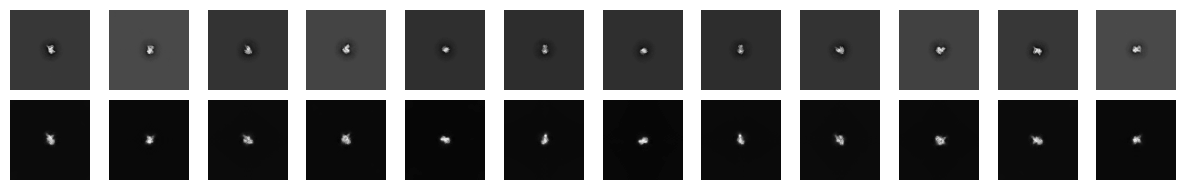

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def plot_projections(imgs, labels=None, max_imgs=1000, nrows=2):
    if len(imgs) > max_imgs:
        imgs = imgs[:max_imgs]

    N = len(imgs)
    ncols = N // nrows

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(ncols, nrows)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    if labels is None:
        labels = [None for _ in axes.ravel()]

    for img, ax, lbl in zip(imgs, axes.ravel(), labels):
        #ax.imshow(img, vmin=-15, vmax=15,cmap="Greys_r")
        ax.imshow(img,cmap="Greys_r")
        if lbl is not None:
            ax.set_title(lbl)
        ax.axis("off")

    plt.tight_layout()
    return fig, axes


plot_projections(iht2_center(torch.cat([q[...,:-1,:-1], t[...,:-1,:-1]])), nrows=2)
#plot_projections(torch.cat([q, t]))

plt.show()

In [7]:
((t - t.mean(dim=(-1,-2), keepdim=True)) * (q - q.mean(dim=(-1,-2), keepdim=True)) /  t.std(dim=(-1,-2), keepdim=True) / q.std(dim=(-1,-2), keepdim=True)).mean(dim=(-1,-2)) 

tensor([0.6903, 0.7822, 0.7052, 0.6566, 0.7268, 0.7329, 0.7268, 0.7329, 0.7052,
        0.6566, 0.6903, 0.7822])

In [8]:
import math
print(corr.max())
print(corr.min())

tensor(0.7172, device='cuda:0')
tensor(0.5269, device='cuda:0')


In [9]:
br_corr, bestrots = corr.max(dim=-1)
_, besttrans = torch.max(br_corr, dim=-1)
bestrot = bestrots.gather(-1, besttrans.unsqueeze(-1))

In [10]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Create a Rotation object from the matrix
rotation = R.from_matrix(rots2[bestrot.squeeze()].cpu().numpy())

# Get Euler angles in 'xyz' order (roll, pitch, yaw) in degrees
euler_angles = rotation.as_euler('xyz', degrees=True)
print(euler_angles)

[17.13389053 16.41526858 47.48955721]


In [11]:
voldata = torch.load("../siren_vols.pt")

/tmp/ipykernel_914755/3288447827.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  voldata = torch.load("../siren_vols.pt")


In [12]:
# analyze data from search
import torch

#res = torch.load("../search_results/cryosparc_P25_J411_008_volume_map_search_res_rot1_trans1_extent0_hartley_postfilternum64_transpf0_numtranspf1_rotpf2.pt")
res = torch.load("../search_results/cryosparc_P25_J411_008_volume_map_search_res_rot1_trans1_extent0_hartley.pt")
#res = torch.load("../search_results/cryosparc_P25_J411_008_volume_map_search_res_rot1_trans1_extent0_hartley_old.pt")

/tmp/ipykernel_914755/2540141791.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load("../search_results/cryosparc_P25_J411_008_volume_map_search_res_rot1_tr

In [13]:
maxcorr = res['corr'].amax(dim=(-1,-2))
#if 'unique_indices' in res:
#    maxcorr[:, res['unique_indices']] = res['corr_pf'].amax(dim=(-1,-2))
bestcors, idxs = maxcorr.sort(descending=True)
bestids = voldata['ids'][idxs][0]

In [14]:
res['corr_pf'].shape

KeyError: 'corr_pf'

In [15]:
bestids[:10]

tensor([28087, 26563, 27871, 27265, 28108, 17088, 26097, 28545, 27264, 25618])

In [16]:
bestcors[:,:10]

tensor([[0.7843, 0.7583, 0.7525, 0.7409, 0.7403, 0.7401, 0.7282, 0.7231, 0.7192,
         0.7176]])

In [17]:
corr = res['corr']
br_corr, bestrots = corr.max(dim=-1)
_, besttrans = torch.max(br_corr, dim=-1)
bestrot = bestrots.gather(-1, besttrans.unsqueeze(-1))
bestrots_sorted = bestrot[torch.arange(idxs.shape[0]).unsqueeze(1),idxs].squeeze()

In [18]:
# Create a Rotation object from the matrix
rotations = R.from_matrix(rots2[bestrots_sorted].cpu().numpy())

# Get Euler angles in 'xyz' order (roll, pitch, yaw) in degrees
euler_angles_best = rotations.as_euler('xyz', degrees=True)

In [19]:
euler_angles_best[:10]

array([[ 4.59279746e+01,  1.65729182e+01, -1.72937086e+02],
       [ 4.59279804e+01, -1.65729216e+01,  5.29370857e+01],
       [-1.71338884e+01,  1.64152670e+01, -1.74895527e+01],
       [ 4.59279746e+01,  1.65729182e+01, -1.72937086e+02],
       [ 7.05287753e+01, -3.91741668e-08,  1.49999999e+01],
       [ 1.79999997e+02, -7.05287791e+01,  1.05000005e+02],
       [-1.71338872e+01, -1.64152683e+01, -1.25104471e+01],
       [-1.71338872e+01, -1.64152683e+01, -1.25104471e+01],
       [ 1.71338905e+01,  1.64152686e+01,  4.74895572e+01],
       [-4.59279746e+01, -1.65729182e+01,  7.06291415e+00]])

In [20]:
# analyze the val2025 3d runs
import pickle 
import os
from analyze_search_outputs import incorporate_postfiltered, score_hits, select_best_maps

emds = [x[:-1].lower().replace('-','_') for x in open("../val2025_maps.txt",'r').readlines()]
results = {}
suffix = "_search_res_rot1_trans1_extent0_hartley_3d_postfilternum64_transpf0_numtranspf1_rotpf2.pt"

for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/search_results2/' + e + suffix):
        res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='cpu')

        for k,v in res.items():
            if k in results:
                results[k].append(v)
            else:
                results[k]  = [v]

results = {k: torch.stack(v) if (torch.is_tensor(v[0]) and k not in  ("unique_indices", "corr_pf")) else v for k,v in results.items()}

search_terms = [["doublet", "microtubule"],
                ["complex i"],
                ["apoferritin"],
                ["spike", "sars-cov-2"],
                ["nucleosome"],
                ["fof1", "atp synthase"],
                ["70s"], 
                ["cas9", "spcas9"],
                ["actin"],
                ["hiv;capsid", "hiv;hexamer"],
                ["cdc37", "hsp90"]]

all_topics = sorted(pickle.load(open("../emdb_topics.pkl", 'rb')), key=lambda x:x[0])

dat = torch.load("../train_projections.pt")
dat_val = torch.load("../val_projections.pt")
ids_all = torch.cat([dat['ids'], dat_val['ids']])

topics_dict = {emd.item() : x for emd,x in zip(ids_all, all_topics)}


/tmp/ipykernel_914755/3396912507.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='cp

In [23]:
import matplotlib.pyplot as plt

maxk = 64
corr_all = results['corr'].amax(dim=(1,-1,-2))
hit_indices = corr_all.topk(maxk, dim=-1)[1]
hit_ids = voldata['ids'][hit_indices]

hit_acc = score_hits(topics_dict, hit_ids, search_terms)
cum_acc = (hit_acc.cumsum(dim=-1) > 0).to(torch.float)

def derangement(n):
    perm = torch.randperm(n)
    for i in range(n):
        if perm[i] == i:  # If an element is in its original place, swap it
            perm[i], perm[(i+1) % n] = perm[(i+1) % n], perm[i]
    return perm

hit_acc_wrong = score_hits(topics_dict, hit_ids[derangement(11)], search_terms)
cum_acc_wrong = (hit_acc_wrong.cumsum(dim=-1) > 0).to(torch.float)

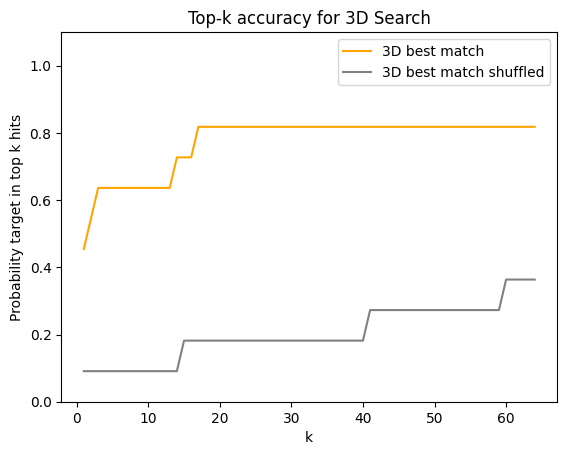

tensor(49.4545)


In [30]:
plt.plot(torch.arange(cum_acc.shape[-1]) + 1, cum_acc.mean(dim=0), color="orange", label="3D best match")
plt.plot(torch.arange(cum_acc_wrong.shape[-1]) + 1, cum_acc_wrong.mean(dim=0), color="grey", label="3D best match shuffled")

plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for 3D Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

print(cum_acc.mean(dim=0).sum(dim=-1))


In [ ]:
hit_indices.shape